In [441]:
import ArticleComparator as ac
import csv 
import pandas as pd 
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pickle

sns.set_context("paper")
sns.set_style("darkgrid")
sns.set_theme(palette="flare")

from graph import Graph

In [442]:
truth_graph = Graph()
truth_graph.update_graph("data/categories.tsv", mode='Initialization', verbose=False )
truth_graph.update_graph("data/links.tsv", mode='g', verbose=False)

# Exploring the graph gided by semantics:

**The idea of this part is to understand how people hwo won the game did to navigate through this huge graph. More specifically we try to see how semantic did influnce the chosen paths.**

To do so we first start by creating a dataframe that contains all the finished paths.
The data frame will have 4 entries at this stage :
- The path : which is the list of nodes that the player went through
- Start : the starting node
- End : the ending node
- length : the length of the path

However we will discard paths where backclicking is done.

In [606]:
# Create a df with path, start, end, length
df_paths_finished = pd.DataFrame(columns=['path', 'start', 'end', 'length'])
counter = 0
discarded_paths = 0

# Read the paths from the paths_finished.tsv file
with open("data/paths_finished.tsv",encoding="utf8") as file:
            tsv_file = csv.reader(file, delimiter="\t")
            #For each line in the file
            for line in tsv_file:
                # Skip empty or commented lines 
                if len(line)==0 or line[0].startswith("#"):
                    continue
                else:   
                    path = line[3].split(';')
                    if path.__contains__('<') or path.__contains__('Pikachu'):
                        discarded_paths += 1
                        continue
                    # Set the start node as the fist node in the path
                    start = path[0]
                    # Set the end node as the last node in the path
                    end = path[-1]
                    # Set the length of the path
                    length = len(path)
                    # Add the path to the dataframe
                    df_paths_finished.loc[counter] = [path, start, end, length]
                    counter += 1
print("Discarded paths due to backclicks: ", discarded_paths)
print("Number of paths retained: ", len(df_paths_finished))

Discarded paths due to backclicks:  9052
Number of paths retained:  42266


For obvious reasons we will also discard trivial paths (length 1)

In [607]:
print("Number of trivial paths: ", len(df_paths_finished[df_paths_finished['length'] == 1]))
df_paths_finished = df_paths_finished[df_paths_finished['length'] > 1]

Number of trivial paths:  11


In [608]:
df_paths_finished

,path,start,end,length
0,"[14th_century, 15th_century, 16th_century, Pac...",14th_century,African_slave_trade,9
1,"[14th_century, Europe, Africa, Atlantic_slave_...",14th_century,African_slave_trade,5
2,"[14th_century, Niger, Nigeria, British_Empire,...",14th_century,African_slave_trade,8
3,"[14th_century, Renaissance, Ancient_Greece, Gr...",14th_century,Greece,4
4,"[14th_century, Italy, Roman_Catholic_Church, H...",14th_century,John_F._Kennedy,7
...,...,...,...,...
42261,"[Work_%28thermodynamics%29, Energy, Aristotle,...",Work_%28thermodynamics%29,Film,13
42262,"[Yagan, Ancient_Egypt, Civilization]",Yagan,Civilization,3
42263,"[Yagan, Australia, England, France, United_Sta...",Yagan,U.S._Open_%28tennis%29,7
42264,"[Yarralumla%2C_Australian_Capital_Territory, A...",Yarralumla%2C_Australian_Capital_Territory,Abraham_Lincoln,4


Next we want to see if the link chosen by the player are sementically closer or not to the target article.
Here we distinguish 2 metrics :
- Article similarity 
- Tile similarity

Article similarity is the similarity between the target article and the article that the player clicked on. <br>
Tile similarity is the similarity between the title of the target article and the title of the article that the player clicked on.

In order to compute these metrics we use the BERT model to compute the embeddings of the articles and the titles.
Then we compute the cosine similarity between the embeddings.

We cretated an object of type ArticleComparator that stores the embeddings of the articles and the titles.
Now we will use the methods of this object to compute the similarity metrics.

In [609]:
#Initiate the comparator
article_list = truth_graph.articles
article_comparator = ac.ArticleComparator("data/plaintext_articles/", article_list)

In [610]:
# For each path, compute the similarity between the articles in the path and the end article
df_paths_finished['article_similarity'] = df_paths_finished.apply(lambda row: [article_comparator.compare_articles(article, row['end']) for article in row['path']], axis=1)
# For each path, compute the similarity between the title of the articles in the path and the title of the end article
df_paths_finished['title_similarity'] = df_paths_finished.apply(lambda row: [article_comparator.compare_titles(article, row['end']) for article in row['path']], axis=1)

In [611]:
df_paths_finished.sample(10)

,path,start,end,length,article_similarity,title_similarity
1063,"[Bamako, United_States, India, Hinduism, Swast...",Bamako,Sun,6,"[0.51, 0.64, 0.58, 0.43, 0.48, 1.0]","[0.46, 0.55, 0.53, 0.51, 0.44, 1.0]"
15577,"[Winter, Snow, Water, Life, Animal, Mammal, Li...",Winter,Carnivore,8,"[0.35, 0.34, 0.49, 0.54, 0.58, 0.68, 0.79, 1.0]","[0.44, 0.41, 0.44, 0.5, 0.63, 0.67, 0.45, 1.0]"
40501,"[Theatre, Music, Folk_music, Natural_selection...",Theatre,Zebra,9,"[0.5, 0.42, 0.47, 0.58, 0.63, 0.59, 0.64, 0.68...","[0.31, 0.4, 0.27, 0.47, 0.44, 0.52, 0.58, 0.62..."
35228,"[Mancala, Europe, Czech_Republic]",Mancala,Czech_Republic,3,"[0.57, 0.57, 1.0]","[0.41, 0.52, 1.0]"
5007,"[Linguistics, Middle_East, Irrigation, Rain, A...",Linguistics,Climate_change,7,"[0.6, 0.65, 0.62, 0.65, 0.75, 0.64, 1.0]","[0.39, 0.45, 0.43, 0.53, 0.52, 0.84, 1.0]"
13929,"[Tin, Chemical_element, Sulfur, Nature, Solar_...",Tin,Earth,6,"[0.76, 0.58, 0.72, 0.44, 0.8, 1.0]","[0.75, 0.65, 0.6, 0.68, 0.61, 1.0]"
14368,"[Immanuel_Kant, Mathematics, Science, Chemistr...",Immanuel_Kant,Aluminium_chloride,8,"[0.6, 0.61, 0.58, 0.69, 0.85, 0.77, 0.91, 1.0]","[0.47, 0.41, 0.49, 0.54, 0.57, 0.58, 0.86, 1.0]"
32479,"[Glasses, Titanium, Periodic_table, Zirconium]",Glasses,Zirconium,4,"[0.6, 0.94, 0.7, 1.0]","[0.58, 0.64, 0.73, 1.0]"
35398,"[Marvin_Gaye, United_Kingdom, Christianity, Re...",Marvin_Gaye,Mysticism,5,"[0.51, 0.62, 0.62, 0.73, 1.0]","[0.5, 0.55, 0.56, 0.68, 1.0]"
4716,"[Japan, United_Nations, English_language, Old_...",Japan,Greece,9,"[0.58, 0.63, 0.54, 0.55, 0.54, 0.66, 0.66, 0.7...","[0.55, 0.47, 0.33, 0.29, 0.48, 0.58, 0.53, 0.5..."


In [612]:
# pickle the dataframe
with open('data/df_paths_finished.pickle', 'wb') as handle:
    pickle.dump(df_paths_finished, handle, protocol=pickle.HIGHEST_PROTOCOL)

# load the dataframe
with open('data/df_paths_finished.pickle', 'rb') as handle:
    df_paths_finished = pickle.load(handle)

Todo We can ask ourselvers if the similarity metrics are correlated with the length of the path.

We can wonder if 

In [598]:
def percentage_increase(sequence):
  # Initialize the score to 0
  score = 0
  # Loop through the numbers in the sequence, starting at the second number
  for i in range(1, len(sequence)-1):
    if sequence[i] > sequence[i-1]:
      score += 1
  return (score/((len(sequence)-1))).__round__(2)

In [599]:
df_paths_finished['percentage_inc_article_sim'] = df_paths_finished.apply(lambda row: percentage_increase(row['article_similarity']), axis=1)
df_paths_finished['percentage_inc_title_sim'] = df_paths_finished.apply(lambda row: percentage_increase(row['title_similarity']), axis=1)

<AxesSubplot: xlabel='percentage_inc_article_sim', ylabel='Count'>

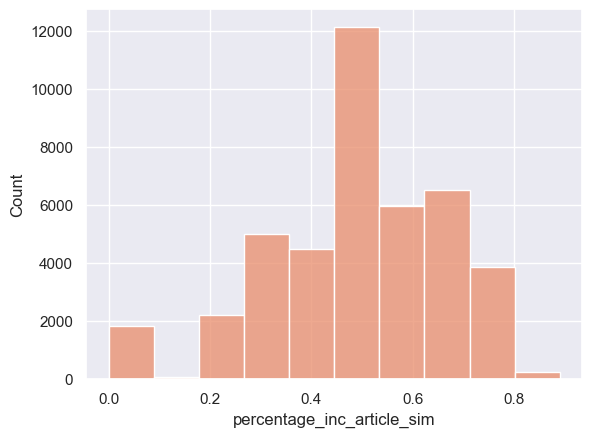

In [600]:
sns.histplot(data=df_paths_finished, x="percentage_inc_article_sim", bins=10, stat="count")

Now we need a way to evaluate the quality of the paths.
We consider that a path is good if it get semantically closer to the target article :
- [0.26, 0.38, 0.48, 1.0] is a good path because the similarity is increasing
- [0.26, 0.38, 0.28, 0.4, 0.20, 1.0] is a bad path because the similarity is oscillating

In [601]:
def path_score(sequence):
  # Initialize the score to 0
  score = 0
  
  # Loop through the numbers in the sequence, starting at the second number
  for i in range(1, len(sequence)-1):
    # If the difference between the current number and the previous number is less than 0.05, add 0 to the score
    if np.abs(sequence[i] - sequence[i-1]) < 0.05:
      score += 0
    # If the next article is more similar than the previous article, add 1 to the score
    elif sequence[i] > sequence[i-1]:
      score += 1
    # If the next article is less similar than the previous article, subtract 1 from the score
    elif sequence[i] < sequence[i-1]:
      score -= 1
    
  return (score/((len(sequence)-1))).__round__(2)


We assign to each path two scores :
- The score of the path based on the article similarity 
- The score of the path based on the title similarity

In [602]:
df_paths_finished['score_article_similarity'] = df_paths_finished.apply(lambda row: path_score(row['article_similarity']), axis=1)
df_paths_finished['score_title_similarity'] = df_paths_finished.apply(lambda row: path_score(row['title_similarity']), axis=1)

In [603]:
df_paths_finished.sort_values(by=['score_article_similarity'], ascending=False)

,path,start,end,length,article_similarity,title_similarity,percentage_inc_article_sim,percentage_inc_title_sim,score_article_similarity,score_title_similarity
8364,"[Vitamin_C, United_States, Natural_gas, Gas, H...",Vitamin_C,Comet,7,"[0.32, 0.44, 0.55, 0.6, 0.69, 0.8, 1.0]","[0.39, 0.53, 0.56, 0.58, 0.5, 0.46, 1.0]",0.83,0.50,0.83,0.00
7464,"[Commonwealth_Games, English_language, Languag...",Commonwealth_Games,Computational_chemistry,7,"[0.35, 0.49, 0.61, 0.68, 0.73, 0.89, 1.0]","[0.28, 0.43, 0.44, 0.63, 0.72, 0.81, 1.0]",0.83,0.83,0.83,0.67
14035,"[Juice, New_Zealand, Bird_of_prey, Osprey, Fos...",Juice,Triceratops,7,"[0.33, 0.55, 0.61, 0.68, 0.73, 0.97, 1.0]","[0.41, 0.49, 0.29, 0.56, 0.64, 0.76, 1.0]",0.83,0.67,0.83,0.50
13652,"[Deity, Christianity, Spain, Christopher_Colum...",Deity,Effect_of_Hurricane_Katrina_on_New_Orleans,7,"[0.42, 0.53, 0.58, 0.64, 0.73, 0.82, 1.0]","[0.24, 0.22, 0.28, 0.3, 0.67, 0.88, 1.0]",0.83,0.67,0.83,0.50
36674,"[Ordinary_differential_equation, Isaac_Newton,...",Ordinary_differential_equation,Baltic_Sea,6,"[0.43, 0.56, 0.66, 0.75, 0.93, 1.0]","[0.36, 0.33, 0.44, 0.45, 0.64, 1.0]",0.80,0.60,0.80,0.40
...,...,...,...,...,...,...,...,...,...,...
20539,"[Baghdad, Football, Football_%28soccer%29, Lat...",Baghdad,Latin_America,4,"[0.75, 0.49, 0.43, 1.0]","[0.49, 0.32, 0.26, 1.0]",0.00,0.00,-0.67,-0.67
24571,"[Californium, Chemical_element, Periodic_table...",Californium,Phosphorus,4,"[0.91, 0.75, 0.65, 1.0]","[0.63, 0.7, 0.69, 1.0]",0.00,0.33,-0.67,0.33
9979,"[Laika, United_States, Yellowstone_National_Pa...",Laika,Human,4,"[0.73, 0.61, 0.56, 1.0]","[0.62, 0.57, 0.23, 1.0]",0.00,0.00,-0.67,-0.67
2307,"[California, North_America, Europe, Czech_Repu...",California,Czech_Republic,4,"[0.68, 0.62, 0.57, 1.0]","[0.39, 0.61, 0.52, 1.0]",0.00,0.33,-0.67,0.00


Then we classify the paths based on the score of the article similarity and the score of the title similarity.
- **Type 0 paths:**  paths that have similar score for both article similarity and title similarity
- **Type 1 paths:**  paths that have better score for article similarity than title similarity
- **Type 2 paths:**  paths that have better score for title similarity than article similarity

In [559]:
df_paths_finished['type'] = df_paths_finished.apply(lambda row: 0 if row['score_article_similarity'] == row['score_title_similarity'] else (1 if row['score_article_similarity'] > row['score_title_similarity'] else 2), axis=1)

In [560]:
# show proportion of paths with score 0, 1, 2
df_paths_finished['type'].value_counts(normalize=True).to_frame().sort_index()

,type
0,0.344078
1,0.333002
2,0.322920


We can see that the paths are evenly distributed along the types. <br>
Let's see how the path types are distributed along the the different paths lengths. <br>

Before doing so, we drop all paths of non frquenet lengths(that are inferior to 100) since they are not representative of the whole population.

In [561]:
# drop the entries where the length appear less than 100 times
print("Number of paths before filtering: ", len(df_paths_finished))
df_paths_multiple = df_paths_finished.groupby('length').filter(lambda x: len(x) > 100)
print("Number of paths after filtering: ", len(df_paths_multiple))

Number of paths before filtering:  42255
Number of paths after filtering:  41914


Let's now see the distribution of the path lengths based on the type of the path.

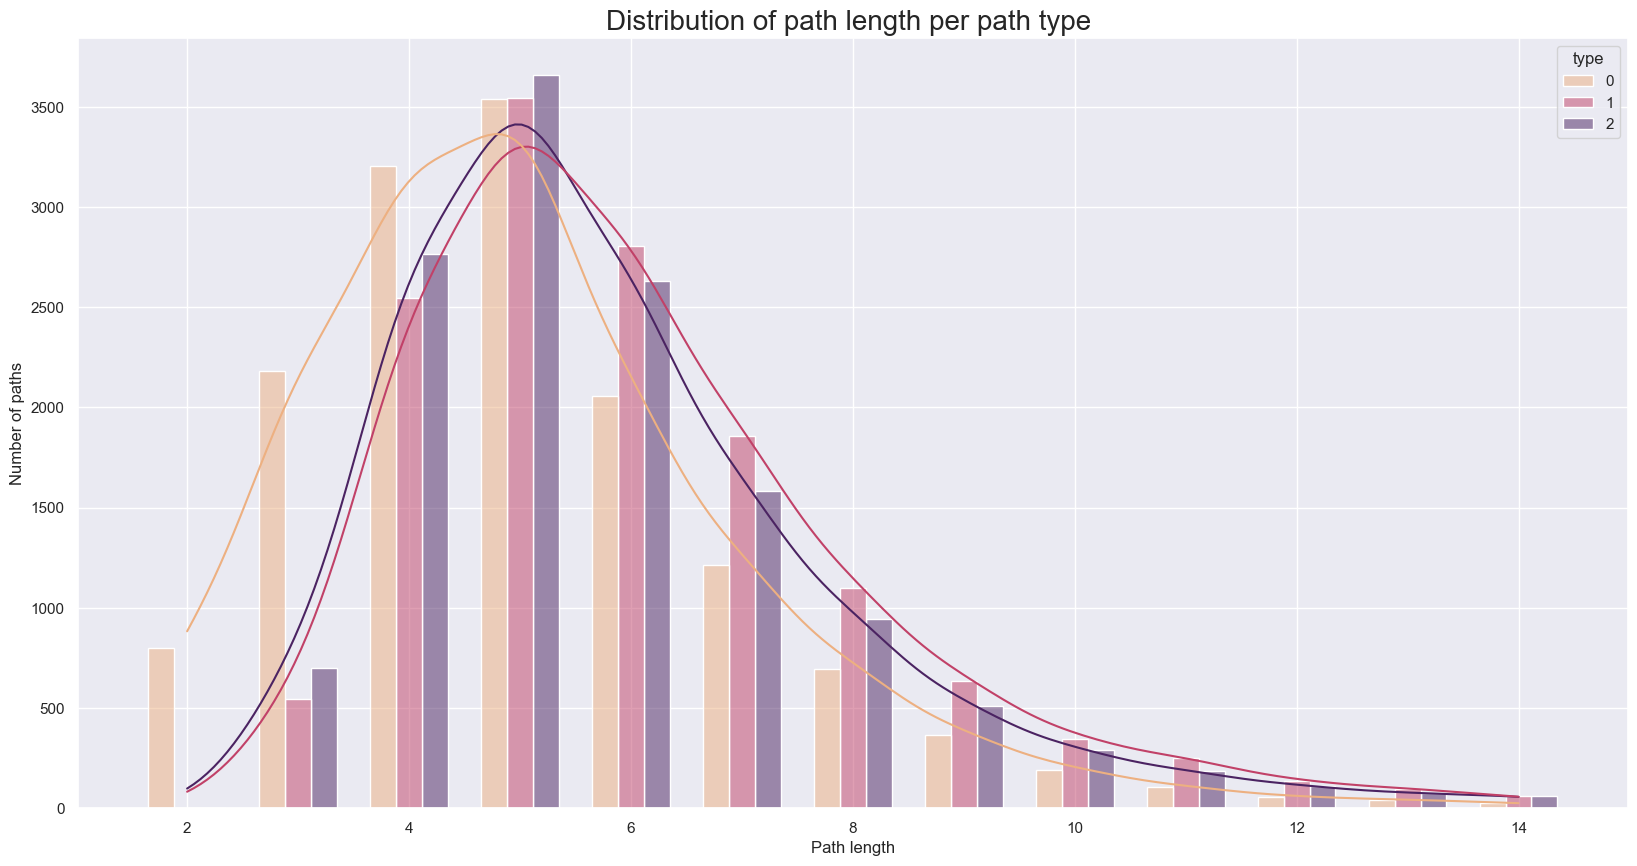

Average path length:  5.617216204609439
Median path length:  5.0
Standard deviation of path length:  2.0090258529655713


In [562]:
# plot the distribution of the type per length using hue type histplot plot and kde=true, 
sns.set_context("paper")
sns.set_style("darkgrid")
sns.set_theme(palette="flare")
fig, ax = plt.subplots( figsize=(20, 10))
sns.histplot(data=df_paths_multiple, x="length", hue="type",bins=35,stat = 'count',discrete= True, shrink=0.7,
  multiple="dodge", palette="flare", kde=True, ax=ax, kde_kws={'bw_method': 0.28})
ax.set_xlabel("Path length")
ax.set_ylabel("Number of paths")
ax.set_title("Distribution of path length per path type ", fontsize=20)
plt.show()

# print average, median path length and standard deviation
print("Average path length: ", df_paths_multiple['length'].mean())
print("Median path length: ", df_paths_multiple['length'].median())
print("Standard deviation of path length: ", df_paths_multiple['length'].std())

In [563]:
df_paths_multiple.groupby('type')['length'].mean().to_frame()


,length
type,
0,5.044814
1,6.022272
2,5.813439


From the above plot we can see that type 0 paths are the most frequent one when the length of the path is small (<4). <br>
This is not surprising since the scores for content and title similarity are likely to evolve similarly in such short paths <br> <br>
However, starting from length 6 we see a predominance of type 2 paths : as the solution becomes less obvious, the player is more likely to click on a link that has a similar title to the target article. <br>

<AxesSubplot: title={'center': 'Proportion of paths types per length'}, xlabel='length'>

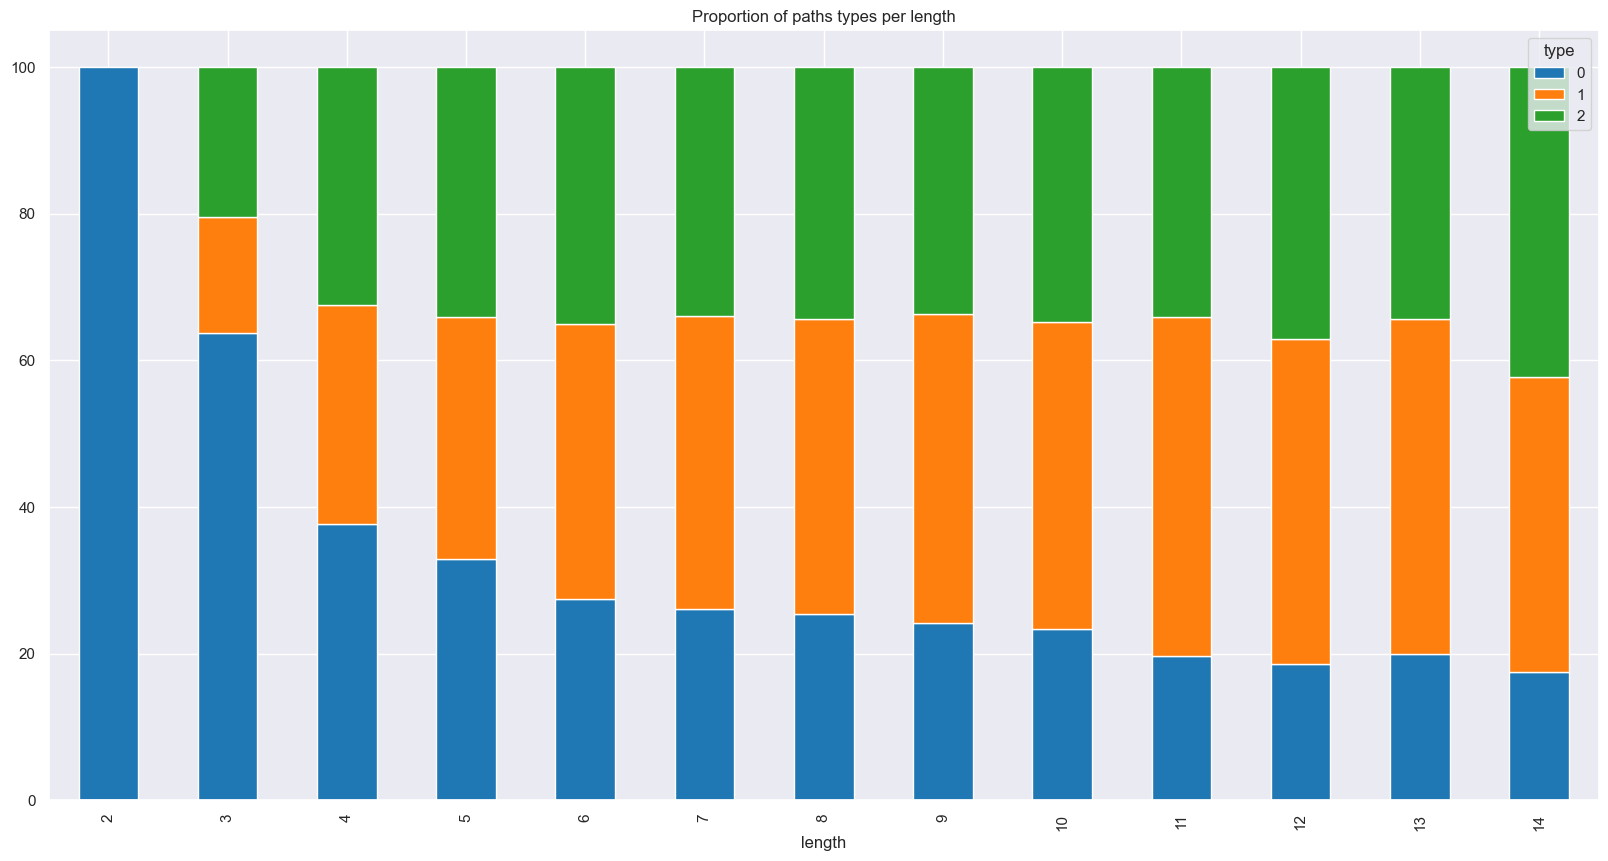

In [564]:
# plot the percentage of playerType 0, 1, 2 per length 
type_repartition = df_paths_multiple.groupby(['length', 'type'], group_keys=False).size().groupby(level=0, group_keys=False).apply(lambda x: 100 * x / float(x.sum())).unstack()

# set the color of the bars
fig, ax = plt.subplots(figsize=(10, 5))
colors = ["#1f77b4", "#ff7f0e", "#2ca02c"]
type_repartition.plot(kind='bar', stacked=True, figsize=(20,10), title='Proportion of paths types per length', color=colors, ax=ax)

 Todo : Interpret the results from above 
 

Knowing that the three types  <br><br>
To do so we have to compare the average length of type 0, type1 and type 2 paths by doing an observational study.<br>
Thus, we do matchings between type 0 1 and 2 paths based on the start and end article. <br>

First we keep start and end articles that are common to all the types of paths. <br>


In [565]:
# group df_paths_multiple usinf start end and count the number of different types
df_paths_multiple_grouped = df_paths_multiple.groupby(['start', 'end']).agg({'type': lambda x: len(x.value_counts())})

# Get start end that are represented in the three types of paths
df_paths_multiple_grouped = df_paths_multiple_grouped[df_paths_multiple_grouped['type'] == 3]

# print the number of start end that are represented in the three types of paths
print("Number of start end that are represented in the three types of paths: ", len(df_paths_multiple_grouped))

# in df_paths_multiple keep only the rows where start and end are in df_paths_multiple_grouped
matching = df_paths_multiple[df_paths_multiple.apply(lambda row: (row['start'], row['end']) in df_paths_multiple_grouped.index, axis=1)]
# keep columns start, end, length, type, path
matching = matching[['start', 'end', 'length', 'type']]

Number of start end that are represented in the three types of paths:  593


Then we compute the average length of the paths for each type of path. <br>


In [566]:
# group by end start and type and average the length
matching = matching.groupby(['start', 'end', 'type'], as_index=False).mean()

In [567]:
matching.head(6)

,start,end,type,length
0,12th_century,Zimbabwe,0,5.5
1,12th_century,Zimbabwe,1,9.0
2,12th_century,Zimbabwe,2,5.0
3,14th_century,Elizabeth_I_of_England,0,4.0
4,14th_century,Elizabeth_I_of_England,1,4.0
5,14th_century,Elizabeth_I_of_England,2,6.0


Finally we merge paths with same start and end articles and compute the average length of the paths for each type of path. <br>

In [568]:
# inner join on df_paths_multiple with itself on start and end
matching = matching.merge(matching, on=['start', 'end'])
# drop the rows where the path_x is equal to the path_y
matching = matching[matching['type_x'] != matching['type_y']]

In [569]:
matching.head(7)

,start,end,type_x,length_x,type_y,length_y
1,12th_century,Zimbabwe,0,5.5,1,9.0
2,12th_century,Zimbabwe,0,5.5,2,5.0
3,12th_century,Zimbabwe,1,9.0,0,5.5
5,12th_century,Zimbabwe,1,9.0,2,5.0
6,12th_century,Zimbabwe,2,5.0,0,5.5
7,12th_century,Zimbabwe,2,5.0,1,9.0
10,14th_century,Elizabeth_I_of_England,0,4.0,1,4.0


In [570]:
def print_stats (df, type_x, type_y):
    match = df[(df['type_x'] == type_x) & (df['type_y'] == type_y)]
    # average type x path length 
    print("Average type " , type_x , " path length: ", match['length_x'].mean().__round__(2))
    # average type y path length
    print("Average type " , type_y , " path length: ", match['length_y'].mean().__round__(2))
    # average difference between type x and type y path length
    print("Average difference between type " , type_x,  " and ", type_y, ":"  , (match['length_x'] - match['length_y']).mean().__round__(2))
    # average relative decrease in path length
    print("Average relative decrease in path length: ", ((match['length_x'] - match['length_y']).mean()/match['length_x'].mean()).__round__(2))

In [571]:
print_stats (matching, 0, 1)

Average type  0  path length:  5.74
Average type  1  path length:  6.32
Average difference between type  0  and  1 : -0.58
Average relative decrease in path length:  -0.1


In [572]:
print_stats (matching, 0, 2)

Average type  0  path length:  5.74
Average type  2  path length:  6.18
Average difference between type  0  and  2 : -0.44
Average relative decrease in path length:  -0.08


In [573]:
print_stats (matching, 1, 2)

Average type  1  path length:  6.32
Average type  2  path length:  6.18
Average difference between type  1  and  2 : 0.14
Average relative decrease in path length:  0.02


We can conclude that the type O paths are on average the shortest ones. <br>


# Further analysis will come soon 

# Unfinished paths

In [574]:
# create a df with path, start, end, length
df_paths_unfinished = pd.DataFrame(columns=['path', 'start', 'end', 'length'])
counter = 0

# chek that a list of string named articles contains all elements list of string named list2
def contains_all(articles, path):
    for element in path:
        if not articles.__contains__(element):
            return False
    return True

with open("data/paths_unfinished.tsv",encoding="utf8") as file:
            tsv_file = csv.reader(file, delimiter="\t")
            for line in tsv_file:
                # Skip empty or commented lines 
                if len(line)==0 or line[0].startswith("#"):
                    continue
                else:   
                    path = line[3].split(';')
                    if path.__contains__('<') or path.__contains__('Pikachu') or line[4]=='Pikachu' or not contains_all(article_list, path) or not article_list.__contains__(line[4]):
                        continue
                    
                    start = path[0]
                    end = line[4]
                    length = len(path)
                    df_paths_unfinished.loc[counter] = [path, start, end, length]
                    counter += 1

In [575]:
df_paths_unfinished

,path,start,end,length
0,[Obi-Wan_Kenobi],Obi-Wan_Kenobi,Microsoft,1
1,[Julius_Caesar],Julius_Caesar,Caracas,1
2,"[Malawi, Democracy, Alexander_the_Great]",Malawi,First_Crusade,3
3,[Paraguay],Paraguay,Mount_St._Helens,1
4,"[Paraguay, Bolivia]",Paraguay,Mount_St._Helens,2
...,...,...,...,...
19624,"[Wine, Georgia_%28country%29, Russia]",Wine,History_of_post-Soviet_Russia,3
19625,"[Turks_and_Caicos_Islands, United_States, Iraq...",Turks_and_Caicos_Islands,Iraq_War,6
19626,[Modern_history],Modern_history,Hollandic,1
19627,"[Jamaica, United_Kingdom, World_War_II, Battle...",Jamaica,Alan_Turing,4


In [576]:
# drop paths of length 1
df_paths_unfinished = df_paths_unfinished[df_paths_unfinished['length'] > 1]

In [577]:
df_paths_unfinished['article_similarity'] = df_paths_unfinished.apply(lambda row: [article_comparator.compare_articles(article, row['end']) for article in row['path']], axis=1)
df_paths_unfinished['title_similarity'] = df_paths_unfinished.apply(lambda row: [article_comparator.compare_titles(article, row['end']) for article in row['path']], axis=1)

/var/folders/jg/bpl2xhc13x17j6txgdvzf5940000gn/T/ipykernel_26334/1972011756.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_paths_unfinished['article_similarity'] = df_paths_unfinished.apply(lambda row: [article_comparator.compare_articles(article, row['end']) for article in row['path']], axis=1)
/var/folders/jg/bpl2xhc13x17j6txgdvzf5940000gn/T/ipykernel_26334/1972011756.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_paths_unfinished['title_similarity'] = df_paths_unfinished.apply(lambda row:

In [578]:
df_paths_unfinished

,path,start,end,length,article_similarity,title_similarity
2,"[Malawi, Democracy, Alexander_the_Great]",Malawi,First_Crusade,3,"[0.6, 0.5, 0.7]","[0.39, 0.36, 0.5]"
4,"[Paraguay, Bolivia]",Paraguay,Mount_St._Helens,2,"[0.61, 0.66]","[0.43, 0.47]"
5,"[Agriculture, History_of_the_world, China, Yan...",Agriculture,Grand_Canal_of_China,4,"[0.28, 0.62, 0.59, 0.79]","[0.18, 0.37, 0.76, 0.56]"
6,"[Mind, Christianity, Europe, Renaissance, Anci...",Mind,Scouting,7,"[0.48, 0.51, 0.37, 0.5, 0.42, 0.41, 0.36]","[0.58, 0.43, 0.52, 0.49, 0.31, 0.4, 0.54]"
7,"[4-2-0, United_States, Agriculture, Sugar, Aus...",4-2-0,Cane_Toad,5,"[0.49, 0.62, 0.39, 0.64, 0.65]","[0.45, 0.3, 0.34, 0.57, 0.29]"
...,...,...,...,...,...,...
19623,"[Montenegro, World_War_II, United_States, Cari...",Montenegro,Hurricane_Georges,7,"[0.63, 0.67, 0.66, 0.61, 0.76, 0.84, 0.9]","[0.37, 0.4, 0.37, 0.45, 0.85, 0.79, 0.75]"
19624,"[Wine, Georgia_%28country%29, Russia]",Wine,History_of_post-Soviet_Russia,3,"[0.38, 0.71, 0.75]","[0.22, 0.4, 0.75]"
19625,"[Turks_and_Caicos_Islands, United_States, Iraq...",Turks_and_Caicos_Islands,Iraq_War,6,"[0.55, 0.62, 0.76, 0.65, 0.8, 0.74]","[0.25, 0.5, 0.9, 0.48, 0.63, 0.7]"
19627,"[Jamaica, United_Kingdom, World_War_II, Battle...",Jamaica,Alan_Turing,4,"[0.58, 0.62, 0.6, 0.54]","[0.41, 0.6, 0.41, 0.41]"


In [579]:
df_paths_unfinished['score_article_similarity'] = df_paths_unfinished.apply(lambda row: path_score(row['article_similarity']), axis=1)
df_paths_unfinished['score_title_similarity'] = df_paths_unfinished.apply(lambda row: path_score(row['title_similarity']), axis=1)

/var/folders/jg/bpl2xhc13x17j6txgdvzf5940000gn/T/ipykernel_26334/4230566007.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_paths_unfinished['score_article_similarity'] = df_paths_unfinished.apply(lambda row: path_score(row['article_similarity']), axis=1)
/var/folders/jg/bpl2xhc13x17j6txgdvzf5940000gn/T/ipykernel_26334/4230566007.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_paths_unfinished['score_title_similarity'] = df_paths_unfinished.apply(lambda row: path_score(row['title_similarity'])

In [580]:
df_paths_unfinished

,path,start,end,length,article_similarity,title_similarity,score_article_similarity,score_title_similarity
2,"[Malawi, Democracy, Alexander_the_Great]",Malawi,First_Crusade,3,"[0.6, 0.5, 0.7]","[0.39, 0.36, 0.5]",-0.50,0.00
4,"[Paraguay, Bolivia]",Paraguay,Mount_St._Helens,2,"[0.61, 0.66]","[0.43, 0.47]",0.00,0.00
5,"[Agriculture, History_of_the_world, China, Yan...",Agriculture,Grand_Canal_of_China,4,"[0.28, 0.62, 0.59, 0.79]","[0.18, 0.37, 0.76, 0.56]",0.33,0.67
6,"[Mind, Christianity, Europe, Renaissance, Anci...",Mind,Scouting,7,"[0.48, 0.51, 0.37, 0.5, 0.42, 0.41, 0.36]","[0.58, 0.43, 0.52, 0.49, 0.31, 0.4, 0.54]",-0.17,0.00
7,"[4-2-0, United_States, Agriculture, Sugar, Aus...",4-2-0,Cane_Toad,5,"[0.49, 0.62, 0.39, 0.64, 0.65]","[0.45, 0.3, 0.34, 0.57, 0.29]",0.25,0.00
...,...,...,...,...,...,...,...,...
19623,"[Montenegro, World_War_II, United_States, Cari...",Montenegro,Hurricane_Georges,7,"[0.63, 0.67, 0.66, 0.61, 0.76, 0.84, 0.9]","[0.37, 0.4, 0.37, 0.45, 0.85, 0.79, 0.75]",0.17,0.17
19624,"[Wine, Georgia_%28country%29, Russia]",Wine,History_of_post-Soviet_Russia,3,"[0.38, 0.71, 0.75]","[0.22, 0.4, 0.75]",0.50,0.50
19625,"[Turks_and_Caicos_Islands, United_States, Iraq...",Turks_and_Caicos_Islands,Iraq_War,6,"[0.55, 0.62, 0.76, 0.65, 0.8, 0.74]","[0.25, 0.5, 0.9, 0.48, 0.63, 0.7]",0.40,0.40
19627,"[Jamaica, United_Kingdom, World_War_II, Battle...",Jamaica,Alan_Turing,4,"[0.58, 0.62, 0.6, 0.54]","[0.41, 0.6, 0.41, 0.41]",0.00,0.00


In [581]:
# add column 0 if score article  = score tile, 1 id score article > score title, 2 if score article < score title
df_paths_unfinished['type'] = df_paths_unfinished.apply(lambda row: 0 if row['score_article_similarity'] == row['score_title_similarity'] else 1 if row['score_article_similarity'] > row['score_title_similarity'] else 2, axis=1)

/var/folders/jg/bpl2xhc13x17j6txgdvzf5940000gn/T/ipykernel_26334/3392773228.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_paths_unfinished['type'] = df_paths_unfinished.apply(lambda row: 0 if row['score_article_similarity'] == row['score_title_similarity'] else 1 if row['score_article_similarity'] > row['score_title_similarity'] else 2, axis=1)


In [582]:
df_paths_unfinished['percentage_inc_article_sim'] = df_paths_unfinished.apply(lambda row: percentage_increase(row['article_similarity']), axis=1)
df_paths_unfinished['percentage_inc_title_sim'] = df_paths_unfinished.apply(lambda row: percentage_increase(row['title_similarity']), axis=1)


/var/folders/jg/bpl2xhc13x17j6txgdvzf5940000gn/T/ipykernel_26334/1413818998.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_paths_unfinished['percentage_inc_article_sim'] = df_paths_unfinished.apply(lambda row: percentage_increase(row['article_similarity']), axis=1)
/var/folders/jg/bpl2xhc13x17j6txgdvzf5940000gn/T/ipykernel_26334/1413818998.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_paths_unfinished['percentage_inc_title_sim'] = df_paths_unfinished.apply(lambda row: percentage_increase(ro

In [583]:
df_paths_unfinished

,path,start,end,length,article_similarity,title_similarity,score_article_similarity,score_title_similarity,type,percentage_inc_article_sim,percentage_inc_title_sim
2,"[Malawi, Democracy, Alexander_the_Great]",Malawi,First_Crusade,3,"[0.6, 0.5, 0.7]","[0.39, 0.36, 0.5]",-0.50,0.00,2,0.00,0.00
4,"[Paraguay, Bolivia]",Paraguay,Mount_St._Helens,2,"[0.61, 0.66]","[0.43, 0.47]",0.00,0.00,0,0.00,0.00
5,"[Agriculture, History_of_the_world, China, Yan...",Agriculture,Grand_Canal_of_China,4,"[0.28, 0.62, 0.59, 0.79]","[0.18, 0.37, 0.76, 0.56]",0.33,0.67,2,0.33,0.67
6,"[Mind, Christianity, Europe, Renaissance, Anci...",Mind,Scouting,7,"[0.48, 0.51, 0.37, 0.5, 0.42, 0.41, 0.36]","[0.58, 0.43, 0.52, 0.49, 0.31, 0.4, 0.54]",-0.17,0.00,2,0.33,0.33
7,"[4-2-0, United_States, Agriculture, Sugar, Aus...",4-2-0,Cane_Toad,5,"[0.49, 0.62, 0.39, 0.64, 0.65]","[0.45, 0.3, 0.34, 0.57, 0.29]",0.25,0.00,1,0.50,0.50
...,...,...,...,...,...,...,...,...,...,...,...
19623,"[Montenegro, World_War_II, United_States, Cari...",Montenegro,Hurricane_Georges,7,"[0.63, 0.67, 0.66, 0.61, 0.76, 0.84, 0.9]","[0.37, 0.4, 0.37, 0.45, 0.85, 0.79, 0.75]",0.17,0.17,0,0.50,0.50
19624,"[Wine, Georgia_%28country%29, Russia]",Wine,History_of_post-Soviet_Russia,3,"[0.38, 0.71, 0.75]","[0.22, 0.4, 0.75]",0.50,0.50,0,0.50,0.50
19625,"[Turks_and_Caicos_Islands, United_States, Iraq...",Turks_and_Caicos_Islands,Iraq_War,6,"[0.55, 0.62, 0.76, 0.65, 0.8, 0.74]","[0.25, 0.5, 0.9, 0.48, 0.63, 0.7]",0.40,0.40,0,0.60,0.60
19627,"[Jamaica, United_Kingdom, World_War_II, Battle...",Jamaica,Alan_Turing,4,"[0.58, 0.62, 0.6, 0.54]","[0.41, 0.6, 0.41, 0.41]",0.00,0.00,0,0.33,0.33


In [584]:
# drop the entries where the length appear less than 10 times
df_paths_multiple_u = df_paths_unfinished.groupby('length').filter(lambda x: len(x) > 100)

<AxesSubplot: title={'center': 'Proportion of paths types per length'}, xlabel='length'>

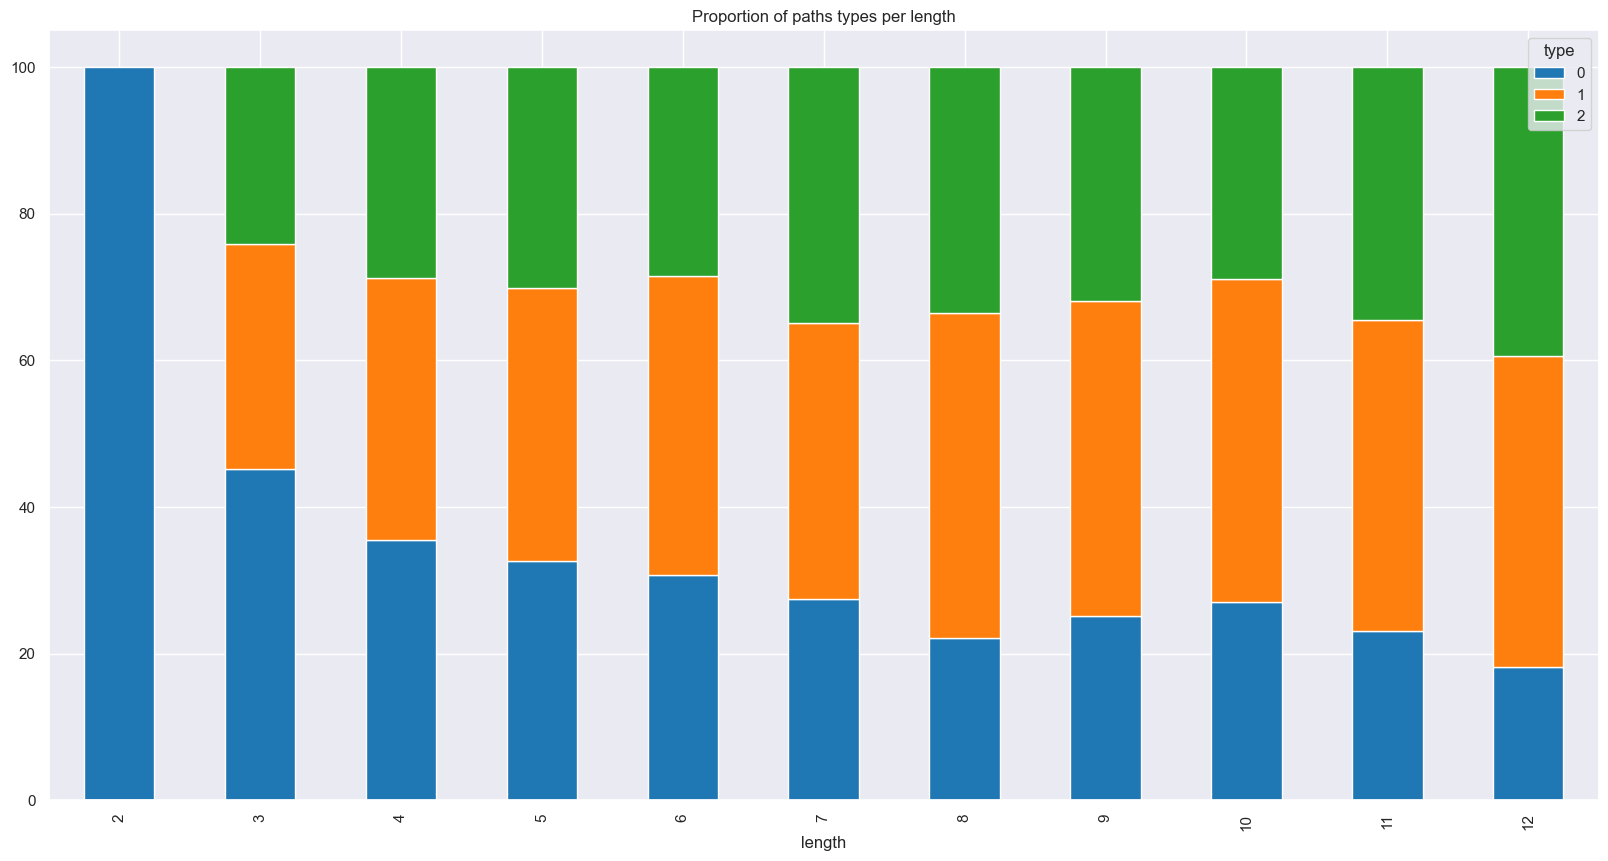

In [585]:
# plot the percentage of playerType 0, 1, 2 per length 
frite = df_paths_multiple_u.groupby(['length', 'type'], group_keys=False).size().groupby(level=0, group_keys=False).apply(lambda x: 100 * x / float(x.sum())).unstack()

# set the color of the bars
fig, ax = plt.subplots(figsize=(10, 5))
colors = ["#1f77b4", "#ff7f0e", "#2ca02c"]
frite.plot(kind='bar', stacked=True, figsize=(20,10), title='Proportion of paths types per length', color=colors, ax=ax)


<AxesSubplot: xlabel='length', ylabel='Count'>

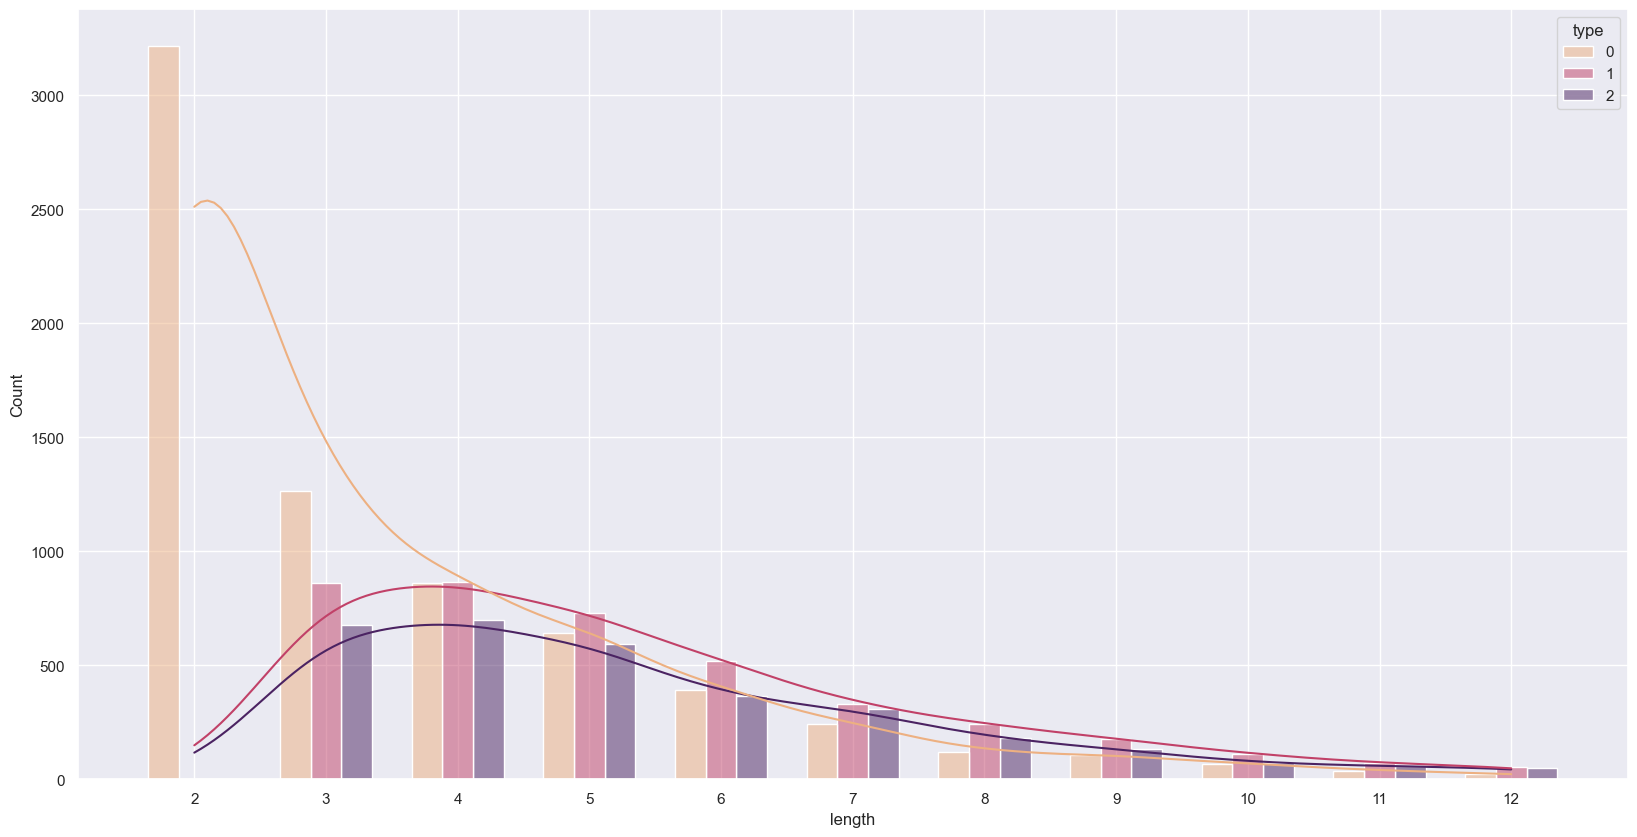

In [586]:
# plot the distribution of the type per length using hue type histplot plot and kde=true, 
sns.set_context("paper")
sns.set_style("darkgrid")
sns.set_theme(palette="flare")
fig, ax = plt.subplots( figsize=(20, 10))
# make sure that the x axis is exatly the same as the one given to the functioon

# change xticks to range(1, 22) to see the distribution of the length #
ax.set_xticks(range(1, 22))

sns.histplot(data=df_paths_multiple_u, x="length", hue="type",bins=35,stat = 'count',discrete= True, shrink=0.7,
  multiple="dodge", palette="flare", kde=True, ax=ax, kde_kws={'bw_method': 0.28})

# Filter paths on length 2 


In [587]:
# filter paths of length 2 in df_paths_multiple_u and df_paths_multiple
df_paths_multiple_u_2 = df_paths_multiple_u[df_paths_multiple_u['length'] > 2]
df_paths_multiple_2 = df_paths_multiple[df_paths_multiple['length'] > 2]

<AxesSubplot: xlabel='percentage_inc_article_sim', ylabel='Percent'>

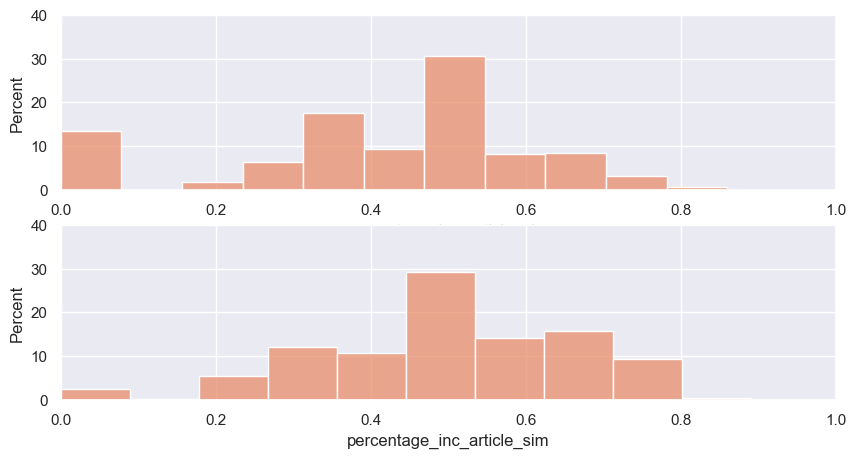

In [588]:
fig, ax = plt.subplots(2, figsize=(10, 5))
# force y axis to be between 0 and 40
ax[0].set_ylim(0, 40)
ax[1].set_xlim(0, 1)
ax[1].set_ylim(0, 40)
ax[0].set_xlim(0, 1)
sns.histplot(data=df_paths_multiple_u_2, x="percentage_inc_article_sim",bins=11,stat = 'percent', ax=ax[0])
sns.histplot(data=df_paths_multiple_2, x="percentage_inc_article_sim",bins=10,stat = 'percent', ax=ax[1])

<AxesSubplot: xlabel='percentage_inc_title_sim', ylabel='Percent'>

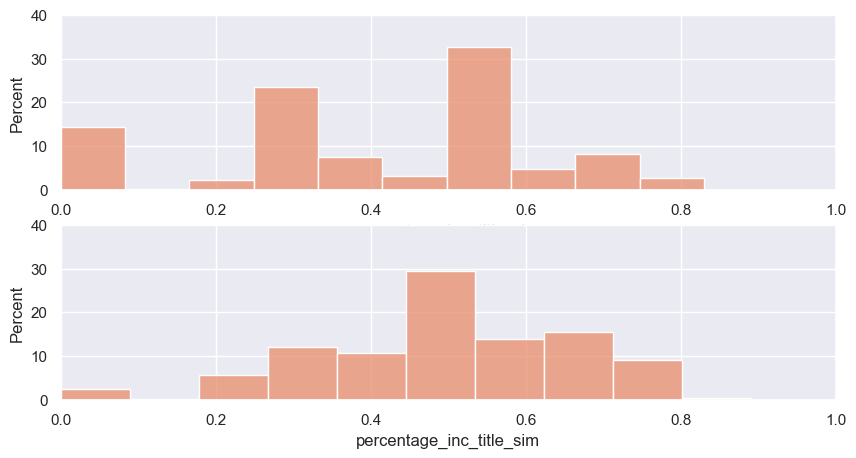

In [589]:
fig, ax = plt.subplots(2, figsize=(10, 5))
# force y axis to be between 0 and 40
ax[0].set_ylim(0, 40)
ax[1].set_xlim(0, 1)
ax[1].set_ylim(0, 40)
ax[0].set_xlim(0, 1)
sns.histplot(data=df_paths_multiple_u_2, x="percentage_inc_title_sim",bins=10,stat = 'percent', ax=ax[0])
sns.histplot(data=df_paths_multiple_2, x="percentage_inc_title_sim",bins=10,stat = 'percent', ax=ax[1])

<AxesSubplot: xlabel='score_article_similarity', ylabel='Percent'>

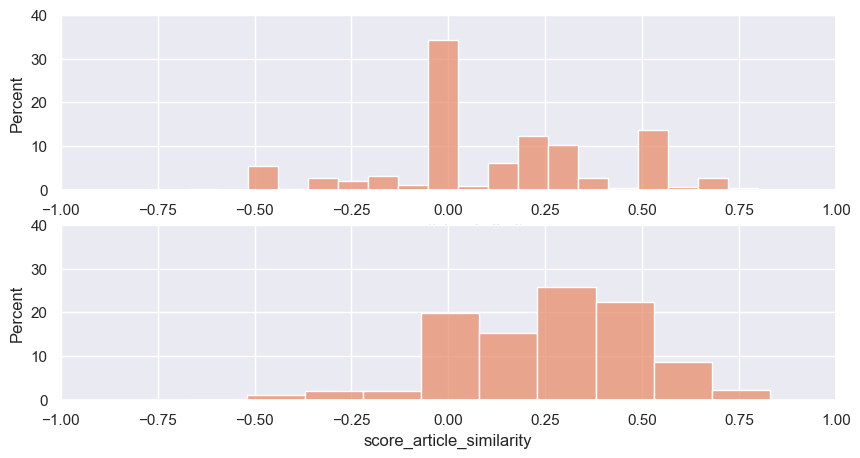

In [590]:
fig, ax = plt.subplots(2, figsize=(10, 5))
# force y axis to be between 0 and 40
ax[0].set_ylim(0, 40)
ax[1].set_xlim(-1, 1)
ax[1].set_ylim(0, 40)
ax[0].set_xlim(-1, 1)
sns.histplot(data=df_paths_multiple_u_2, x="score_article_similarity",bins=20,stat = 'percent', ax=ax[0])
sns.histplot(data=df_paths_multiple_2, x="score_article_similarity",bins=10,stat = 'percent', ax=ax[1])

<AxesSubplot: xlabel='score_title_similarity', ylabel='Percent'>

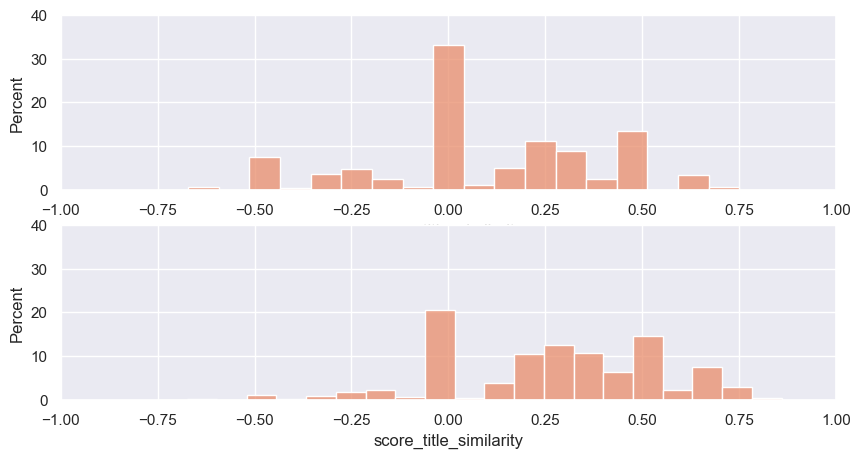

In [591]:
fig, ax = plt.subplots(2, figsize=(10, 5))
# force y axis to be between 0 and 40
ax[0].set_ylim(0, 40)
ax[1].set_xlim(-1, 1)
ax[1].set_ylim(0, 40)
ax[0].set_xlim(-1, 1)
sns.histplot(data=df_paths_multiple_u_2, x="score_title_similarity",bins=20,stat = 'percent', ax=ax[0])
sns.histplot(data=df_paths_multiple_2, x="score_title_similarity",bins=21,stat = 'percent', ax=ax[1])